# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


# План работы:

1. Исследование данных.
2. Работа с пропусками, дубликатами.
3. Поиск аномалий.
4. Выделение целевого признака, создание признаков для обучения.
5. Сведение итоговой таблицы.
5. Обучение моделей, выбор гиперпараметров, проверка адекватности предсказаний, выбор лучшей модели.
6. Тестирование лучшей модели.
7. Составление итогового отчёта.

# Тезисы 1-го вебинара

1. Аномалий по температуре - нет.
2. Особенности таблиц:
  * Температура (`data_temp`). Температура в первом наблюдении по ключу (`key`) - признак, в последнем - целевой признак. Промежуточные значения и их производные применять нельза, так как это будет утечкой данных. Если в наблюдении пропуск в конечной температупе, тогда такое наблюдение - удаляем.
  * Мощность (`data_arc`). Для обучения можно использовать как одну из мощностей, так и их производные (например: суммарная мощность).
  * Сыпучие материалы (`data_bulk`). Пропуски можно заменить нулями, так как начилие пропуска означает, что добавка сыпучих материалов не проводилась.
  * Время добавления сыпучих материалов (`data_bulk_time`). Как признак не используем.
  * Для таблиц по проволке (`data_wire`) и времени добавления проволки (`data_wire_time`) поступаем аналогично сыпучим материалам.
  * Газ (`data_gas`). Данные внутри - суммарный объём газа на исследование.
3. Используем только те ключи (`key`), которые есть во всех таблицах.
4. Несколько наблюдений по одному ключу сводим к одному наблюдению.
5. Из получившейся таблицы признаков и целевого признака выводим первые 10-ть строк.

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 250722

In [3]:
# В таблицах по времени добавления сыпуцих материалов или проволки много столбцов
# в формате даты, приведём их при импорте в соответствующий тип.
bulk_time_col = list(range(1, 16))
wire_time_col = list(range(1, 10))

# Исследование данных

In [4]:
# Импортируем данные из среды яндекс или домашней
try:
    PATH = '/datasets/final_steel/'
    data_arc = pd.read_csv(PATH + 'data_arc.csv',
                           parse_dates=[1, 2])
    data_bulk = pd.read_csv(PATH + 'data_bulk.csv')
    data_bulk_time = pd.read_csv(PATH + 'data_bulk_time.csv',
                                 parse_dates=bulk_time_col)
    data_gas = pd.read_csv(PATH + 'data_gas.csv')
    data_temp = pd.read_csv(PATH + 'data_temp.csv',
                            parse_dates=[1])
    data_wire = pd.read_csv(PATH + 'data_wire.csv')
    data_wire_time = pd.read_csv(PATH + 'data_wire_time.csv',
                                 parse_dates=wire_time_col)
except:
    PATH = '/content/drive/MyDrive/final_steel/'
    data_arc = pd.read_csv(PATH + 'data_arc.csv',
                           parse_dates=[1, 2])
    data_bulk = pd.read_csv(PATH + 'data_bulk.csv')
    data_bulk_time = pd.read_csv(PATH + 'data_bulk_time.csv',
                                 parse_dates=bulk_time_col)
    data_gas = pd.read_csv(PATH + 'data_gas.csv')
    data_temp = pd.read_csv(PATH + 'data_temp.csv',
                            parse_dates=[1])
    data_wire = pd.read_csv(PATH + 'data_wire.csv')
    data_wire_time = pd.read_csv(PATH + 'data_wire_time.csv',
                                 parse_dates=wire_time_col)

In [5]:
# Посмотрим как выглядят данные в таблицах
print('===============================data_arc======================================')
display(data_arc.head(3))
print('===============================data_bulk======================================')
display(data_bulk.head(3))
print('===============================data_bulk_time======================================')
display(data_bulk_time.head(3))
print('===============================data_gas======================================')
display(data_gas.head(3))
print('===============================data_temp======================================')
display(data_temp.head(3))
print('===============================data_wire======================================')
display(data_wire.head(3))
print('===============================data_wire_time======================================')
display(data_wire_time.head(3))

===============================data_arc======================================


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


===============================data_bulk======================================


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


===============================data_bulk_time======================================


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40


===============================data_gas======================================


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


===============================data_temp======================================


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


===============================data_wire======================================


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


===============================data_wire_time======================================


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [6]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [8]:
display(data_bulk.info())
display(data_bulk_time.info())
display(data_wire.info())
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


## Температура

На первый взгляд в таблице обнаружились пропуски, попробуем узнать где они расположились.

In [9]:
data_temp['Время замера'].max(), data_temp['Время замера'].min()

(Timestamp('2019-09-01 04:38:08'), Timestamp('2019-05-03 11:16:18'))

In [10]:
# Посмотрим кол-во уникальных наблюдений
len(data_temp['key'].unique())

3216

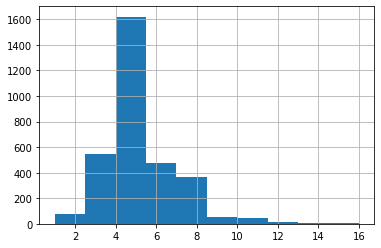

In [11]:
# Построим гистограмму распределения кол-ва наблюдений по ключу
data_temp['key'].value_counts().hist()

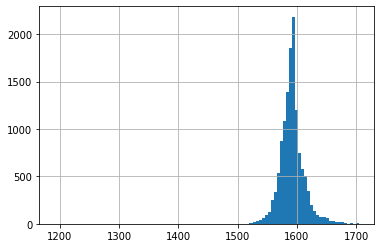

In [12]:
data_temp['Температура'].hist(bins=100)

In [13]:
# Посмотрим общее кол-во пропусков и кол-во пропусков
# в конечной температуре по ключу
print('всего пропусков: ', data_temp['Температура'].isna().sum())
print('из них в конечной температуре:')
(data_temp.sort_values(by=['Время замера'], ascending=False)
          .groupby('key').head(1)['Температура'].isna().sum())

всего пропусков:  2901
из них в конечной температуре:


739

In [14]:
# Посмотрим общее кол-во пропусков по ключу
len(data_temp[data_temp['Температура'].isna()]['key'].unique())

739

In [15]:
pd.DataFrame(list(data_temp[data_temp['Температура'].isna()]['key'].unique())).describe()

,0
count,739.000000
mean,2869.852503
std,213.963364
min,2500.000000
25%,2685.500000
50%,2870.000000
75%,3054.500000
max,3241.000000


In [16]:
# посмотрим как будет выглядеть таблица без пропусков
clear_data_temp = data_temp.query('key < 2500')

In [17]:
clear_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12267 non-null  int64         
 1   Время замера  12267 non-null  datetime64[ns]
 2   Температура   12267 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.3 KB


In [18]:
print('Процент пропусков в уникальных ключах')
(len(data_temp[data_temp['Температура'].isna()]['key'].unique())
    / len(data_temp['key'].unique())) * 100

Процент пропусков в уникальных ключах


22.978855721393035

In [19]:
# Посмотрим величины в очищенных от пропусков данных
clear_data_temp.describe()

,key,Температура
count,12267.000000,12267.000000
mean,1235.589060,1591.999022
std,729.452481,20.833175
min,1.000000,1191.000000
25%,602.000000,1581.000000
50%,1238.000000,1591.000000
75%,1874.000000,1601.000000
max,2499.000000,1705.000000


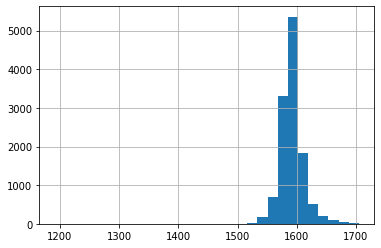

In [20]:
clear_data_temp['Температура'].hist(bins=30)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


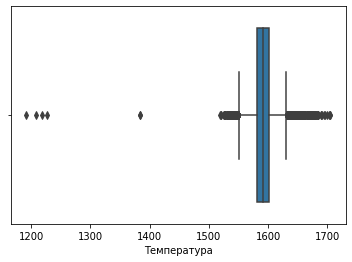

In [21]:
sns.boxplot(clear_data_temp['Температура'])
plt.show()

По температуре:

Из последней гистограммы видно, что есть очень небольшое кол-во значений выбивающиеся за основное распределение находящееся в диапазоне примерно от 1500 до 1705. Заказчик подтвердил, что такие значения имеют место быть, потому мы их оставляем.

Имеются пропуски в замерах температуры. 
* нумерация ключей идёт не по порядку, так как всего уникальных ключей 3216, а максимальный номер ключа 3241
* всего пропусков:  2901
* из них в конечной температуре: 739
* пропуски в данных начинаются при key > 2499 и идут до конца таблицы

* нет ключа 2683 (но это не важно)

В результате убраны ключи с пропусками в конечной или начальной температурах (это ключи уникальный номер которых больше 2499).

Получившаяся таблица названа `clear_data_temp`

In [22]:
clear_data_temp.shape

(12267, 3)

## Мощность

In [23]:
# Посмотрим кол-во уникальных наблюдений
len(data_arc['key'].unique())

3214

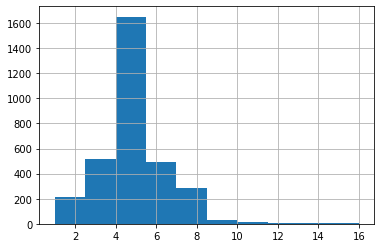

In [24]:
# Построим гистограмму распределения кол-ва наблюдений по ключу
data_arc['key'].value_counts().hist()

In [25]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [26]:
# Отрицательных значений в мощности быть не должно, узнаем номера ключей
data_arc[data_arc['Реактивная мощность'] <= 0]['key']

9780    2116
Name: key, dtype: int64

In [27]:
# Раз уж ключ 1 - посмотрим сколько в нём наблюдений
data_arc[data_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [28]:
# Лучше будет удалить все наблюдения по ключу
data_arc = data_arc[data_arc['key'] != 2116]

In [29]:
data_arc.shape

(14872, 5)

## Сыпучие материалы




При начальном просмотре данных обнаружено довольно большое кол-во пропусков в столбцах. Пропуски обусловлены отсутствием необходимости добавления материалов, соответственно пропуски в таблице можно приравнять к значению 0. Так же пропуски указывают на то, что наблюдение проводилось, соответственно для ключей, которые отсутствуют в данной таблице - наблюдений нет и применять такие ключи для обучения модели нецелесообразно.

In [30]:
# Придётся вызвать info ещё разок, что бы было под рукой
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [31]:
# Посмотрим, соответствует ли кол-во уникальных ключей кол-ву записей
len(data_bulk['key'].unique())

3129

In [32]:
# Ключей оказалось чуть меньше, чем в предыдущих таблицах
# Так же видно, что есть сыпучие материалы, которые применяли
# значительно меньше остальных. Посмотрим как обстоят дела с
# объёмом этих материалов через describe
round(data_bulk.describe())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.0,252.0,22.0,1298.0,1014.0,77.0,576.0,25.0,1.0,19.0,176.0,177.0,2450.0,18.0,2806.0,2248.0
mean,1624.0,39.0,253.0,114.0,104.0,107.0,119.0,306.0,49.0,76.0,83.0,77.0,260.0,181.0,170.0,161.0
std,933.0,18.0,21.0,75.0,48.0,82.0,72.0,191.0,NaN,22.0,26.0,60.0,121.0,46.0,66.0,52.0
min,1.0,10.0,228.0,6.0,12.0,11.0,17.0,47.0,49.0,63.0,24.0,8.0,53.0,151.0,16.0,1.0
25%,816.0,27.0,242.0,58.0,72.0,70.0,70.0,155.0,49.0,66.0,64.0,25.0,204.0,153.0,119.0,105.0
50%,1622.0,31.0,252.0,98.0,102.0,86.0,100.0,298.0,49.0,68.0,86.0,64.0,208.0,156.0,151.0,160.0
75%,2431.0,46.0,258.0,152.0,133.0,132.0,157.0,406.0,49.0,70.0,102.0,106.0,316.0,204.0,206.0,205.0
max,3241.0,185.0,325.0,454.0,281.0,603.0,503.0,772.0,49.0,147.0,159.0,313.0,1849.0,305.0,636.0,405.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


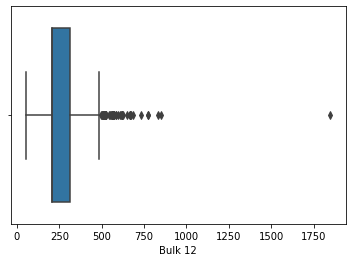

In [33]:
sns.boxplot(data_bulk['Bulk 12'])
plt.show()

In [34]:
data_bulk[data_bulk['Bulk 12'] > 1500]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


In [35]:
clear_data_temp[clear_data_temp['key'] == 322]

,key,Время замера,Температура
1751,322,2019-05-15 09:10:07,1619.0
1752,322,2019-05-15 09:18:07,1632.0
1753,322,2019-05-15 09:40:02,1597.0
1754,322,2019-05-15 09:52:50,1610.0
1755,322,2019-05-15 10:08:04,1604.0
1756,322,2019-05-15 10:14:22,1604.0
1757,322,2019-05-15 10:37:27,1596.0
1758,322,2019-05-15 10:48:07,1600.0
1759,322,2019-05-15 10:53:59,1613.0
1760,322,2019-05-15 10:59:01,1620.0


### Время добавления сыпучих материалов

В целом как признак данную таблицу мы не сможем использовать, однако посмотрим нет ли каких нибудь аномалий в наблюдениях.

In [36]:
data_bulk_time.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40


In [37]:
print('Столбец  Минимальная дата  Максимальная дата')
for col in data_bulk_time.columns:
  print(col,
        data_bulk_time[col].min(),
        data_bulk_time[col].max())


Столбец  Минимальная дата  Максимальная дата
key 1 3241
Bulk 1 2019-05-03 17:50:19 2019-08-30 23:01:32
Bulk 2 2019-05-07 08:36:19 2019-08-08 17:34:38
Bulk 3 2019-05-03 20:13:36 2019-08-31 23:39:11
Bulk 4 2019-05-03 11:21:30 2019-08-30 17:36:30
Bulk 5 2019-05-07 08:36:19 2019-08-28 09:01:08
Bulk 6 2019-05-03 18:52:57 2019-09-01 03:12:40
Bulk 7 2019-05-07 11:37:42 2019-08-31 07:22:25
Bulk 8 2019-07-05 17:46:11 2019-07-05 17:46:11
Bulk 9 2019-05-14 00:04:56 2019-08-11 15:09:33
Bulk 10 2019-05-06 01:36:24 2019-08-30 01:30:42
Bulk 11 2019-05-05 16:45:05 2019-08-31 16:00:49
Bulk 12 2019-05-03 11:03:52 2019-09-01 01:39:41
Bulk 13 2019-05-05 00:39:35 2019-08-26 20:31:16
Bulk 14 2019-05-03 11:03:52 2019-09-01 04:05:34
Bulk 15 2019-05-03 11:03:52 2019-09-01 04:05:34


По сыпучим материалам:

Пропуски показывают наличие наблюдения и в то же - отсутствие необходимости добавлять сыпучие материалы, иначе говоря пропуски можно приравнять к нулю.

Среди сыпучих материалов выделились несколько, которые применяются реже остальных - можно считать, что совсем не применяются. Возможно придётся избавится от таких материалов на этапе подготовки признаков.

Максимальные значения объёмов сыпучих материалов могут зависеть от кол-ва наблюдений\этапов в ключе.

В времени добавления сыпучих материалов ничего необычного не оказалось.

На 322 ключе достигнуты значительно отстоящие от среднего максимумы в 2-х материалах, так же в нём довольно много этапов, что объясняет большой объём добавок.

## Проволка

In [38]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [39]:
# количество записей в key 3081, посмотрим сколько уникальных
len(data_wire['key'].unique())

3081

In [40]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [41]:
# посмотрим что с 322 ключём
data_wire[data_wire['key'] == 322]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
299,322,NaN,188.22855,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


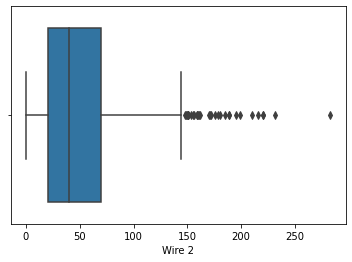

In [42]:
# В 322-ом ничего не обычного, однако есть разбежка по квантилю в Wire 2
sns.boxplot(data_wire['Wire 2'])
plt.show()

In [43]:
# Посмотрим, что за выбитое значение
data_wire[data_wire['Wire 2'] > 250]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1201,1269,142.3656,282.780152,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
clear_data_temp[clear_data_temp['key'] == 1269]

,key,Время замера,Температура
6276,1269,2019-06-18 05:21:21,1627.0
6277,1269,2019-06-18 05:28:07,1615.0
6278,1269,2019-06-18 05:38:06,1604.0
6279,1269,2019-06-18 05:44:11,1601.0
6280,1269,2019-06-18 06:47:25,1568.0
6281,1269,2019-06-18 07:01:45,1568.0
6282,1269,2019-06-18 07:02:17,1582.0
6283,1269,2019-06-18 07:12:54,1575.0
6284,1269,2019-06-18 07:23:00,1581.0
6285,1269,2019-06-18 07:30:24,1584.0


### Время добавление проволки

In [45]:
print('Столбец  Минимальная дата  Максимальная дата')
for col in data_wire_time.columns:
    print(col,
        data_wire_time[col].min(),
        data_wire_time[col].max())

Столбец  Минимальная дата  Максимальная дата
key 1 3241
Wire 1 2019-05-03 11:11:41 2019-09-01 04:16:01
Wire 2 2019-05-03 13:32:06 2019-08-31 18:50:15
Wire 3 2019-05-04 04:47:53 2019-08-28 02:11:18
Wire 4 2019-05-07 08:48:23 2019-08-08 12:03:12
Wire 5 2019-08-08 16:01:07 2019-08-08 16:01:07
Wire 6 2019-05-07 08:37:20 2019-08-14 00:59:11
Wire 7 2019-07-23 12:08:44 2019-08-08 18:27:34
Wire 8 2019-05-14 00:03:32 2019-08-11 15:09:29
Wire 9 2019-05-04 16:09:11 2019-08-29 03:51:31


По проволке:

Ситуация схожая с сыпучими материалами. Так же есть редко используемая проволка. И итоговый объём проволки зависит от кол-ва этапов в ключе.

## Газ

В данных по суммарному объёму газа пропусков не было.

In [46]:
data_gas.shape

(3239, 2)

In [47]:
len(data_gas['key'].unique())

3239

In [48]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


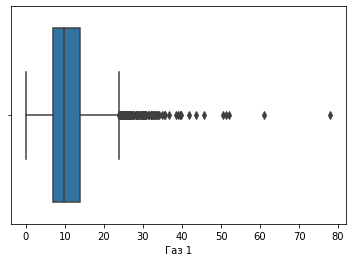

In [49]:
sns.boxplot(data_gas['Газ 1'])
plt.show()

In [50]:
# В объёме газа так же как и с сыпучими материалами и проволкой
# "отвалилось" несколько ключей, посмотрим какое в них кол-во этапов
big_value = data_gas[data_gas['Газ 1'] > 50]['key'].unique()
print('Ключи с наибольшими значениями', big_value)
clear_data_temp[clear_data_temp['key'].isin(big_value)].groupby('key').count()

Ключи с наибольшими значениями [ 117  280  322 2110 2570]


,Время замера,Температура
key,,
117,10,10
280,5,5
322,11,11
2110,9,9


In [51]:
# Ключа с номером 2570 неокаалось, потому как все ключи > 2499
# из таблицы с температурой убрали, в 117, 322 и 2110 много этапов,
# а вот в 280 всего 5 этапов и много газа
display(clear_data_temp.query('key == 280'))
display(data_bulk.query('key == 280'))
data_wire.query('key == 280')

,key,Время замера,Температура
1555,280,2019-05-13 23:20:22,1532.0
1556,280,2019-05-13 23:45:33,1563.0
1557,280,2019-05-13 23:56:43,1584.0
1558,280,2019-05-14 00:05:28,1599.0
1559,280,2019-05-14 00:08:09,1600.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
262,280,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN,108.0,NaN,263.0,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
257,280,160.174557,76.236166,NaN,NaN,NaN,NaN,NaN,46.002319,NaN


По Газу:

- пропусков в данных не обнаружено
- есть 4-ре ключа по которым объём газа больше, чем в остальной таблице
- из этих 4-х в 280 ключе этапов почти в 2 раза меньше, чем в остальных

# Признаки

## Целевой признак

Наш целевой признак - конечная температура. Так же есть признак для обучения - начальная температура. Разделим таблицу.

Целевой признак будет `target_temp`, признак для обучения - `features_temp`. Столбец с временем в признаки входить не должен.

In [52]:
# Выберем конечную температуру по ключу
target_temp = (clear_data_temp.sort_values(by='Время замера', ascending=False)
                              .groupby('key').head(1).copy())
target_temp = target_temp.sort_values(by='key')
# Удалим столбец с временем замера
del target_temp['Время замера']
# Переименуем столбцы, заодно избавимся от кириллицы
target_temp.rename(columns = {'Температура' : 'target_temp'}, inplace = True)

In [53]:
target_temp.head(3)

,key,target_temp
4,1,1613.0
10,2,1602.0
15,3,1599.0


In [54]:
target_temp.shape

(2477, 2)

## Признаки для обучения

### Температура

In [55]:
# Из исследования данных стало понятно, что кол-во этапов в ключе - важно
# посчитаем кол-во этапов по ключу
key_count = clear_data_temp.groupby('key')['Температура'].count()

In [56]:
features_temp = clear_data_temp.sort_values(by='Время замера').groupby('key').head(1).copy()
del features_temp['Время замера']

# это вмешался заказчик
features_temp = features_temp[features_temp['Температура'] > 1499]
features_temp.head(3)

,key,Температура
0,1,1571.0
5,2,1581.0
11,3,1596.0


In [57]:
features_temp = pd.merge(features_temp, key_count, how='left', on='key')
features_temp.rename(columns = {'Температура_x' : 'features_temp',
                                'Температура_y' : 'key_count'}, inplace = True)
features_temp.head(3)

,key,features_temp,key_count
0,1,1571.0,5
1,2,1581.0,6
2,3,1596.0,5


In [58]:
features_temp.shape

(2473, 3)

### Мощность

In [59]:
# Посчитаем продолжительность нагрева дугой
data_arc['total_heat_time'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']

In [60]:
data_arc.head(7)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,total_heat_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0 days 00:02:17
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,0 days 00:05:38


In [61]:
data_arc['total_power'] = ((data_arc['Активная мощность'] ** 2)
                               + (data_arc['Реактивная мощность'] ** 2) ** 0.5)

In [62]:
data_arc['total_heat_time'] = pd.to_timedelta(data_arc['total_heat_time']).dt.total_seconds()

In [63]:
data_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,total_heat_time,total_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,1.639774
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,1.169288
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,1.052882


In [64]:
features_arc = data_arc.groupby('key')['total_heat_time'].sum().to_frame()

In [65]:
features_arc['total_power'] = data_arc.groupby('key')['total_power'].sum().to_frame()

In [66]:
#features_arc['sum_react_power'] = data_arc.groupby('key')['Реактивная мощность'].sum().to_frame()

In [67]:
# Сбросим индекс key в столбец key
features_arc = features_arc.reset_index()

In [68]:
#del features_arc['sum_active_power']
#del features_arc['sum_react_power']

In [69]:
features_arc.head(3)

,key,total_heat_time,total_power
0,1,1098.0,8.572405
1,2,811.0,4.796331
2,3,655.0,3.298466


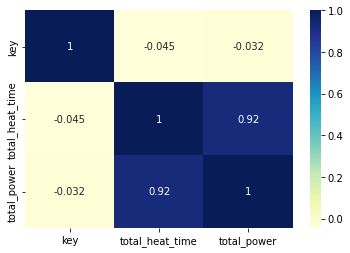

In [70]:
sns.heatmap(features_arc.corr(), cmap="YlGnBu", annot=True)

In [71]:
features_arc.shape

(3213, 3)

### Сыпучие материалы

In [72]:
# Как и планировали пропуски заменяем на 0
data_bulk = data_bulk.fillna(0)

In [73]:
# Просуммируем по столбцам
col_list= list(data_bulk) 
col_list.remove('key')
data_bulk['total_bulk'] = data_bulk[col_list].sum(axis=1)
data_bulk.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,total_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0


In [74]:
features_bulk = data_bulk[['key', 'total_bulk']].copy()
features_bulk.head(3)

,key,total_bulk
0,1,553.0
1,2,582.0
2,3,544.0


In [75]:
features_bulk.shape

(3129, 2)

### Проволка

In [76]:
# Поступаем аналогично сыпучим материалам
data_wire = data_wire.fillna(0)

In [77]:
# Просуммируем по столбцам
col_list= list(data_wire) 
col_list.remove('key')

In [78]:
data_wire['total_wire'] = data_wire[col_list].sum(axis=1)
data_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,total_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [79]:
features_wire = data_wire[['key', 'total_wire']].copy()
features_wire.head(3)

,key,total_wire
0,1,60.059998
1,2,96.052315
2,3,91.160157


In [80]:
features_wire.shape

(3081, 2)

### Газ

In [81]:
data_gas.head(3)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [82]:
data_gas.rename(columns = {'Газ 1' : 'total_gas'}, inplace = True)

In [83]:
features_gas = data_gas.copy()

In [84]:
features_gas.shape

(3239, 2)

# Сведение итоговой таблицы признаков

In [85]:
all_data = pd.merge(features_temp, target_temp, how='left', on='key')
all_data.isna().sum()

key              0
features_temp    0
key_count        0
target_temp      0
dtype: int64

In [86]:
all_data = pd.merge(all_data, features_arc, how='left', on='key')
all_data.isna().sum()

key                0
features_temp      0
key_count          0
target_temp        0
total_heat_time    3
total_power        3
dtype: int64

In [87]:
all_data = pd.merge(all_data, features_bulk, how='left', on='key')
all_data.isna().sum()

key                 0
features_temp       0
key_count           0
target_temp         0
total_heat_time     3
total_power         3
total_bulk         69
dtype: int64

In [88]:
all_data = pd.merge(all_data, features_wire, how='left', on='key')
all_data.isna().sum()

key                  0
features_temp        0
key_count            0
target_temp          0
total_heat_time      3
total_power          3
total_bulk          69
total_wire         104
dtype: int64

In [89]:
all_data = pd.merge(all_data, features_gas, how='left', on='key')
print('Общее кол-во пропусков в столбцах:', all_data.isna().sum().sum())

Общее кол-во пропусков в столбцах: 181


In [90]:
all_data.shape

(2473, 9)

In [91]:
clear_all_data = all_data.dropna(axis=0)
print('Итоговое кол-во удалённых ключей:', all_data.shape[0] - clear_all_data.shape[0])

Итоговое кол-во удалённых ключей: 149


In [92]:
# Ключ нам был нужен для сведения таблиц,
# как признак он нам не нужен, можно сделать его индексом
clear_all_data.set_index('key', inplace=True)

In [93]:
clear_all_data.describe()

,features_temp,key_count,target_temp,total_heat_time,total_power,total_bulk,total_wire,total_gas
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1587.368761,4.979776,1593.372633,808.196644,5.227779,610.083046,125.203274,11.378854
std,23.627590,1.784089,11.207457,340.813828,3.179026,287.574952,63.690752,6.397008
min,1519.000000,2.000000,1541.000000,57.000000,0.199582,19.000000,1.918800,0.008399
25%,1571.000000,4.000000,1587.000000,581.000000,3.065252,440.000000,89.048700,7.282534
50%,1587.000000,5.000000,1593.000000,778.000000,4.664559,609.000000,116.106121,10.100687
75%,1603.000000,6.000000,1598.000000,993.000000,6.670359,796.000000,151.555294,14.218487
max,1660.000000,16.000000,1653.000000,4189.000000,48.830309,3235.000000,568.777664,77.995040


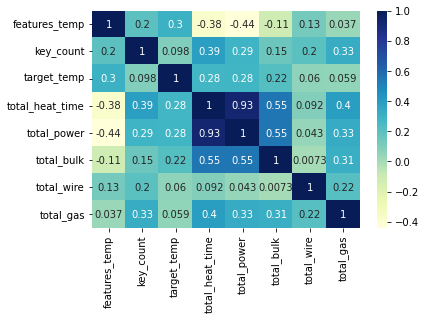

In [94]:
# Построим матрицу корреляции
sns.heatmap(clear_all_data.corr(), cmap="YlGnBu", annot=True)

In [95]:
clear_all_data.head(10)

,features_temp,key_count,target_temp,total_heat_time,total_power,total_bulk,total_wire,total_gas
key,,,,,,,,
1,1571.0,5,1613.0,1098.0,8.572405,553.0,60.059998,29.749986
2,1581.0,6,1602.0,811.0,4.796331,582.0,96.052315,12.555561
3,1596.0,5,1599.0,655.0,3.298466,544.0,91.160157,28.554793
4,1601.0,3,1625.0,741.0,4.970783,595.0,89.063515,18.841219
5,1576.0,2,1602.0,869.0,6.114611,584.0,98.352796,5.413692
6,1543.0,5,1596.0,952.0,7.561183,676.0,108.224477,11.273392
7,1586.0,5,1599.0,673.0,3.973900,627.0,98.061600,9.836267
8,1577.0,4,1598.0,913.0,7.774995,914.0,155.282394,15.171553
9,1587.0,5,1592.0,625.0,2.586241,526.0,122.536960,8.216623


In [96]:
clear_all_data.shape

(2324, 8)

# Обучение моделей

In [97]:
# Функция строющая график предсказания и целевого признака
# ничего не возвращает, только печатает МАЕ и строит график
# принимает на вход
# модель -> model
# обучающие признаки -> feat
# целевой признак -> targ
# так же можно задать название графика -> title
def predict_analys(model, feat, targ, title=''):
    pred = model.predict(feat)
    pred_df = pd.DataFrame(pred, index=targ.index)
    pred_df = pred_df.rename(columns={0:'predict_temp'})
    print('MAE:', mean_absolute_error(targ, pred))
    (pred_df.merge(targ, on='key')
         .sort_values(by='target_temp')
         .reset_index(drop=True)
         .plot.line(alpha=0.5, figsize=(12, 6), title=title))
    plt.show()

## Разделение на выборки

In [98]:
target = clear_all_data['target_temp']
features = clear_all_data.drop('target_temp', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [99]:
# У нас довольно разные величины, отскалируем
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [100]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1743, 7), (581, 7), (1743,), (581,))

## LinearRegression

In [101]:
lr_model = LinearRegression()

In [102]:
lr_grid = {
    'normalize' : [True, False]
}

In [103]:
lr_rs_model = RandomizedSearchCV(lr_model, 
                                        lr_grid,
                                        scoring='neg_mean_absolute_error',
                                        n_iter=2,
                                        random_state=RANDOM_STATE,
                                        cv=3)

In [104]:
%%time
lr_rs_model.fit(features_train, target_train)

CPU times: user 39.1 ms, sys: 2 ms, total: 41.1 ms
Wall time: 85.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pi

RandomizedSearchCV(cv=3, estimator=LinearRegression(), n_iter=2,
                   param_distributions={'normalize': [True, False]},
                   random_state=250722, scoring='neg_mean_absolute_error')

In [105]:
lr_rs_model.best_params_

{'normalize': False}

In [106]:
-lr_rs_model.best_score_

6.54561397127944

## CatBoosting

In [107]:
cat_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, loss_function='MAE')

cat_grid = {
    'learning_rate' : [rate * 0.01 for rate in range(1, 10, 1)],
    'iterations' : [iter for iter in range(1000, 3000, 1000)]
}

In [108]:
cat_rs_model = RandomizedSearchCV(cat_model, 
                                        cat_grid,
                                        scoring='neg_mean_absolute_error',
                                        n_iter=10,
                                        random_state=RANDOM_STATE,
                                        cv=3)

In [109]:
%%time
cat_rs_model.fit(features_train, target_train)

CPU times: user 2min 58s, sys: 22.4 s, total: 3min 20s
Wall time: 2min 4s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f34d4f70a90>,
                   param_distributions={'iterations': [1000, 2000],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04, 0.05, 0.06,
                                                          0.07, 0.08, 0.09]},
                   random_state=250722, scoring='neg_mean_absolute_error')

In [110]:
cat_rs_model.best_params_

{'iterations': 1000, 'learning_rate': 0.03}

In [111]:
-cat_rs_model.best_score_

6.49939521167948

## LGBM

In [112]:
light_model = LGBMRegressor(random_state=RANDOM_STATE)

In [113]:
light_grid = {
    'num_leaves':[leaf for leaf in range(10, 60, 10)],
    'n_estimators':[est for est in range(100, 400, 20)],
    'learning_rate':[rate * 0.01 for rate in range(1, 20, 1)],
}

In [114]:
light_rs_model = RandomizedSearchCV(light_model, 
                                        light_grid,
                                        scoring='neg_mean_absolute_error',
                                        n_iter=20,
                                        random_state=RANDOM_STATE,
                                        cv=5, verbose=1)

In [115]:
%%time
light_rs_model.fit(features_train, target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 1min 7s, sys: 2.82 s, total: 1min 10s
Wall time: 37.9 s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=250722),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04, 0.05, 0.06,
                                                          0.07, 0.08, 0.09, 0.1,
                                                          0.11, 0.12, 0.13,
                                                          0.14, 0.15, 0.16,
                                                          0.17, 0.18, 0.19],
                                        'n_estimators': [100, 120, 140, 160,
                                                         180, 200, 220, 240,
                                                         260, 280, 300, 320,
                                                         340, 360, 380],
                                        'num_leaves': [10, 20, 30, 40, 50]},
                   random_state=250722, scoring='neg_mea

In [116]:
light_rs_model.best_params_

{'learning_rate': 0.07, 'n_estimators': 100, 'num_leaves': 10}

In [117]:
-light_rs_model.best_score_

6.466945484913227

## RandomForest

In [118]:
model = RandomForestRegressor(random_state=RANDOM_STATE, criterion='absolute_error')

grid = {
    'n_estimators':[x for x in range(50, 110, 10)],
    'max_depth':[x for x in range(10, 20, 1)], 
    'min_samples_leaf':[x for x in range(1, 4, 1)],
    'min_samples_split':[x for x in range(2, 6, 1)],
}

In [119]:
%%time
fr_rs_model = RandomizedSearchCV(model, grid, 
                                 scoring='neg_mean_absolute_error', 
                                 n_iter=20, random_state=RANDOM_STATE, cv=5)
fr_rs_model.fit(features_train, target_train)

CPU times: user 7min 2s, sys: 581 ms, total: 7min 3s
Wall time: 7min 2s


In [120]:
fr_rs_model.best_params_

{'max_depth': 13,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 60}

In [121]:
-fr_rs_model.best_score_

6.420850582946346

## Вывод
Меньшее МАЕ на кросс-валидации показала модель RandomForest, её и будем проверять на тестовой выборке.

# Тестирование лучшей модели

MAE: 6.5514343086632225


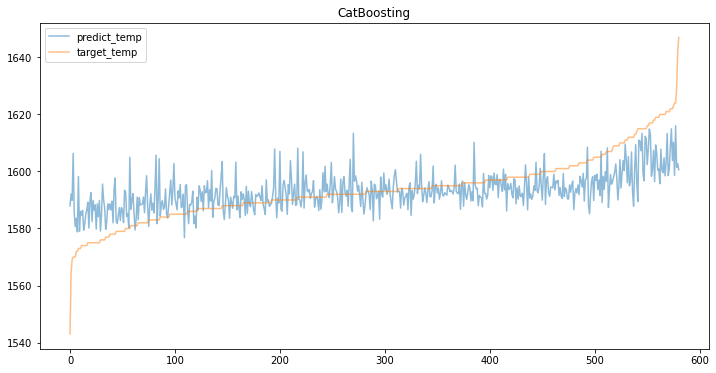

In [122]:
predict_analys(fr_rs_model, features_test, target_test, title='CatBoosting')

По графику видно, что модель плохо улавливает режимы с температурой < 1585 и > 1600, если посмотреть распределение температуры в `Исследование данных -> Температура`, становится понятно, что таких данных для обучения попросту мало.

# Итоговый отчёт.

В процессе решения поставленной выделились следующие основные этапы:

* знакомство с задачей
* уточнение условий задачи
* построение плана предстоящей работы по разработке модели
* исследование и предобработка полученных данных
* подготовка признаков
* обучение моделей
* тестирование лучшей модели
* написание итогового отчёта

После изучения условий задачи были составлены и заданы уточняющие вопросы и выбран целевой признак - температура на конечном наблюдении по ключу. Далее составлен план выполнения работы. По каждому из пунктов плана выполнены соответствующие ему задачи. Для определения лучшей модели в задачи регрессии ключевой метрикой выбрана "средняя абсолютная ошибка" (`MAE`).

В процессе исследования данных таблицы подвергались изменениям:
* из таблицы с результатами измерений температуры `data_temp` были удалены все ключи с пропусками в конечной температуре, получившаяся таблица названа `clear_data_temp`;
* в таблице с данными об электродах `data_arc` был обнаружен ключ с отрицательным значением реактивной мощности, такое значение является ошибкой в данных и ключ, содержащий его был удалён;
* в таблицах с сыпучими материалами `data_bulk` и проволкой `data_wire` были обнаружены пропуски в данных. Принято решение пропуски считать отсутствием добавления добавок и в дальнейшем пропуски были заменены нулями. Так же в этих таблицах обнаружены редко применяемые добавки;
* в таблице с данными о продувке сплава газом `data_gas` проблем обнаружено не было.

В таблицах с сыпучими материалами, проволкой и газом замечен повышенный расход этих ресурсов при увеличении кол-ва этапов в ключе.

В следующем пунке плана "Признаки"- выделены обучающие и целевой признаки:

* из таблицы `clear_data_temp` выделены две таблицы `features_temp` и `target_temp` с начальной и конечной температурами как обучающий и целевой признаки, соответственно;
* в таблице `data_arc` посчитана суммарная мощность по ключу `total_power` и продолжительность нагрева электродом по ключу `total_time_heat` с агрегацией данных по ключу, остальные столбцы удалены (таблица `features_arc`);
* в таблице `data_bulk` посчитана сумма по ключу, а остальные столбцы удалены (таблица `features_bulk`), аналогично и для таблицы `data_wire`(таблица `features_wire`);
* таблица `data_gas` перенесена в `features_gas` и переименованием столбца.

После была сведена итоговая таблица, содержащая обучающие и целевой признаки. С помощью объединения таблиц через уникальные ключи, при этом были исключены ключи отсутствующие в любой из объединяемых таблиц.

   В следующем пунке плана проходило обучение моделей, выбор гиперпараметров, проверка адекватности предсказаний и выбор лучшей модели. Сначала из итоговой таблицы был выделен целевой признак. Далее таблицы с обучающими `features` и целевым `target` признаками была разделена на обучающую (`features_train`, `target_train`) и тестовую (`features_test`, `target_test`) выборки в соотношении 75:25.
   
Всего обучались 4-е модели:
* линейная модель (LinearRegression)
* модели градиентного бустинга: CatBoosting и LightGBM
* модель решающего леса (RandomForest)
Модели обучались спомощью инструмента RandomSearchCV, который позваляет из заданной сетки с гиперпараметрами модели выбрать лучшие гиперпараметры для модели с целью минимизации заданной метрики на кросс-валидации. В результате обучения меньшую МАЕ показала модель RandomForest (`fr_rs_model`) - 6.42 c следующими гиперпараметрами:
    *   max_depth = 13;
    *   min_samples_leaf = 2;
    *   min_samples_split = 5;
    *   n_estimators = 60;
    *   random_state = 250722;
    *   criterion = 'absolute_error'.

Далее проводилось тестирование модели `fr_rs_model` на тестовом наборе данных. Получено значение МАЕ = 6.55.

От плана работы, составленного в самом начале, отступать не пришлось. Основные сложности состояли в том, чтобы выделить обучающие признаки и выбрать гиперпараметры моделей. Что бы правильно выбрать данные для обучающих признаков необходимо, хотя бы поверхностно, понимать природу решаемой задачи(в нашем случае технологического процесса). В выборе гиперпараметров задачу существенно упрощает применённый инструмент `RandomSearchCV`, который позволяет из указанных диапазонов изменения гиперпараметров выбрать лучшие значения для минимизации целевой метрики. Однако, для его работы, в зависимости от модели, размера обучающей выборки и располагаемых вычислительных ресурсов, может потребоваться достаточно много времени. 

